# MSC Geomet - Using Authentication to Access Flow Predictions

This notebook provides examples of how to use user/password authentication on Meteorological Service of Canada's (MSC) [GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#msc-geomet "MSC GeoMet Open Documentation") platform, in order to access flow prediction through the web map service (WMS) and web coverage service (WCS) with Python. If you are unsure of which service to use, a general rule of thumb is that the web map service is primarily used to retrieve geospatial images and the web coverage service is used to retrieve raw geospatial data. If you are new to the WMS and the WCS we recommend later visiting the [additional documentation](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#usage-tutorials-and-technical-documentation "MSC GeoMet Usage, Tutorials, and Technical Documentation") on the MSC Open Data website. If you are an advanced user and you would like additional details, you can view the [technical documentation](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/ "MSC GeoMet Technical Documentation").

## Table of Contents

* [Requirements](#Requirements)
* [Introduction to Web Map Service](#Introduction-to-Web-Map-Service)
* [Non-authenticated vs authenticated data](#Non-athenticated-vs-authenticated-data)
* [Accessing layer information](#Accessing-layer-information)
* [Viewing with WMS](#Viewing-with-WMS)
* [Viewing with Matplotlib/Cartopy](#Viewing-with-Matplotlib-/-Cartopy)
* [Web Coverage Service Examples](#Web-Coverage-Service-Examples)

## Requirements

First, we import all necessary Python libraries.  Some of these are standard Python libraries, while others are third-party libraries that must first be installed in your Python environment. The most important of these third-party libraries is [OWSLib](https://geopython.github.io/OWSLib/index.html "OWSLib Documentation"), which stands for the Open Geospatial Consortium (OGC) web service and which we'll use for accessing the Geomet WMS and WCS. We also recommend [xarray](https://docs.xarray.dev/en/stable/ "xarray Documentation"), for data handling and [cartopy](https://scitools.org.uk/cartopy/docs/latest/) for viewing the data.

In [4]:
# data
import warnings
import re
import time
import configparser
from datetime import datetime, timedelta
import xarray as xr 

# web map services 
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication

# plotting
from IPython.display import Image
import cartopy.crs as ccrs
import cartopy.feature as cf
# matplotlib is a third-party library, but is commonly included in Python distributions for data science
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib import cm

To access the flow prediction from the user/password authenticated version of GeoMet, we need credentials. We can use the built-in configparser utility library, which reads a file with the following format:

```
[Login]
Username = your_user_name 
Password = your_password
```

In [5]:
config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

login = config['Login']

## Introduction to Web Map Service

The Geomet WMS provides access to georeferenced map images, also known as raster images or tiles. These display hydro-meteorological variables from multiple MSC monitoring and numerical modelling systems and their related products.  Included with the map images is descriptive information, i.e., metadata, that includes attributes describing each of the different map images and how they should be displayed.  Together, the descriptive information and images are called layers. 

We can connect to the WMS using OWSlib.  The typical way to do this without authentication is as follows:

In [6]:
# filter warnings or be prepared to see plenty
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

# connect to web map service
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
                    version='1.3.0',
                    timeout=300)

In [7]:
# print the "abstract" for the GeoMet WMS
print(wms.identification.abstract)

GeoMet-Weather provides public access to the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) data via interoperable web services and application programming interfaces (API). Through open standards, users can freely and quickly access thousands of real-time and archived weather, climate and water datasets and products and integrate them in their domain-specific applications and decision support systems. Users can build mobile apps, create interactive web maps, and display and animate MSC data in desktop software. MSC GeoMet also enables on demand raw data clipping and reprojection, on demand format conversion and custom visualization.


In [8]:
# some additional wms metadata
print("URL: " + wms.url)
print("Version: " + wms.version)
print("Provider: " + wms.provider.name)
print("Provider URL: " + wms.provider.url)

URL: https://geo.weather.gc.ca/geomet
Version: 1.3.0
Provider: Government of Canada, Environment and Climate Change Canada, Meteorological Service of Canada
Provider URL: https://eccc-msc.github.io/open-data/msc-geomet/readme_en/


In [9]:
# let's print the operations available from the wms and the product formatting options
for op in wms.operations:
    print(op.name, op.formatOptions)

GetCapabilities ['text/xml']
GetMap ['image/png', 'image/jpeg']
GetFeatureInfo ['text/plain', 'application/json', 'application/vnd.ogc.gml']
DescribeLayer ['text/xml']
GetLegendGraphic ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8']
GetStyles ['text/xml']


In [10]:
# by default, when we connected to the web map service above, we were making a GetCapabilities request
print(wms.request)

https://geo.weather.gc.ca/geomet?service=WMS&request=GetCapabilities&version=1.3.0


<div class="alert alert-block alert-danger">
<b>
!!! No documentation on DescribeLayer in technical documentation. We always connect with GetCapabilities, unless we know a priori what the required parameters are for the other operations such that we can make a complete request?
</div>

## Non-athenticated vs authenticated data

Once we have established a connection to the web map service, we can view the available layers.

In [11]:
# let's have a look at the first 20 data layers in the wms contents
print(len(wms.contents))
for key in list(wms.contents.keys())[0:20]:
    print(key)

3621
Canadian Weather
ALERTS
CURRENT_CONDITIONS
METNOTES
Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA_ICEC
CGSL.ETA_ICEPRS
CGSL.ETA_ICESTG
CGSL.ETA_ICET
CGSL.ETA_ICETK
CGSL.ETA_UICE
CGSL.ETA_UOGRD
CGSL.ETA_UU
CGSL.ETA_WTMP
RDPS convective fields
RDPS.CONV_KINDEX.PT3H
RDPS.CONV_ML-CAPE
RDPS.CONV_ML-CIN
RDPS.CONV_ML-EL-HGT


In [12]:
# let's check what data are available for the Water Cycle Prediction System (WCPS)
for key in list(wms.contents.keys()):
    if "WCPS" in key:
        print(key)

Water Cycle Prediction System (WCPS) [1 km]
WCPS.2D_GE
WCPS.2D_GL
WCPS.2D_MLW
WCPS.2D_SALW
WCPS.2D_SIII
WCPS.2D_SSH
WCPS.2D_STGI
WCPS.2D_TM2
WCPS.2D_TT
WCPS.2D_UU
WCPS.2D_UU2W
WCPS.2D_UUI


This list tells us what the layer names are for the available WCPS data, but they aren't very descriptive. Let's print their titles instead.

In [13]:
# let's have a look at the variable names
for key in list(wms.contents.keys()):
    if "WCPS." in key:
        print(wms[key].title)

WCPS.2D - Volume of sea ice per unit grid cell [m]
WCPS.2D - Sea ice fraction
WCPS.2D - Mixed layer depth based on a density criterion [m]
WCPS.2D - Sea Water Salinity [psu]
WCPS.2D - Vertically integrated ice internal pressure [N/m]
WCPS.2D - Sea surface height with respect to the geoid [m]
WCPS.2D - Vertically integrated compressive ice strength [N/m]
WCPS.2D - Sea temperature [K]
WCPS.2D - Air temperature [K]
WCPS.2D - Winds [m/s]
WCPS.2D - Ocean current [m/s]
WCPS.2D - Ice velocity [m/s]


Now we have a better idea of what layers are available. Note that we don't have river discharge listed here. Let's check what we have available for the Deterministic and Ensemble Hydrologic Prediction Systems (DHPS and EHPS).

In [14]:
# look for DHPS or EHPS, nothing returned
for key in list(wms.contents.keys()):
    if "DHPS" in key or "EHPS" in key:
        print(key)

The reason we don't see any data for DHPS and EHPS is that the layers are not just password-protected, they are completely hidden.

To connect to the authenticated version of WMS, we do one of the following:

In [15]:
# pass the layer name to the request
layer_name = 'DHPS_1km_RiverDischarge'

# use username and password parameters individually
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    username=login['Username'],
                    password=login['Password'],
                    timeout=300)

for key in list(wms.contents.keys()):
    print(key)

Deterministic Hydrological Prediction System (DHPS) [1 km]
DHPS
DHPS_1km_RiverDischarge


In [16]:
# use auth parameter with Authentication utility
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

for key in list(wms.contents.keys()):
    print(key)

Deterministic Hydrological Prediction System (DHPS) [1 km]
DHPS
DHPS_1km_RiverDischarge


The second approach with `auth = Authentication(username, password)` is preferable since it is the only method that works with the Web Coverage Service.

Note again that all layers are hidden.  You can see this by connecting to the WMS and providing authentication, but no layer information is available:

In [17]:
# use auth parameter with Authentication utility
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

# looking for WCPS, DHPS or EHPS, still no flow predictions are returned
for key in list(wms.contents.keys()):
    if "WCPS" in key or "DHPS" in key or "EHPS" in key:
        print(key)

Water Cycle Prediction System (WCPS) [1 km]
WCPS.2D_GE
WCPS.2D_GL
WCPS.2D_MLW
WCPS.2D_SALW
WCPS.2D_SIII
WCPS.2D_SSH
WCPS.2D_STGI
WCPS.2D_TM2
WCPS.2D_TT
WCPS.2D_UU
WCPS.2D_UU2W
WCPS.2D_UUI


<div class="alert alert-block alert-warning">
<b>So to use the authenticated version of Geomet, whether WMS or WCS, you have to provide the layer name as well as the authentication information, which means you need to know the layer name you're looking for in advance of the request.
</div>

Luckily, here's a list of layers:

In [18]:
# DHPS_1km_CorrectedFlowDir
# DHPS_1km_DeepReservoirStorage_PT24H
# DHPS_1km_DrainageArea
# DHPS_1km_Evap-SpatialAvg12h_PT12H
# DHPS_1km_Precip-SpatialAvg12h_PT12H
# DHPS_1km_RiverChannelStorage_PT24H
# DHPS_1km_RiverDischarge
# DHPS_1km_TotalRunoff-Avg12h_PT12H
# DHPS_1km_WaterbodyID
# DHPS-Analysis_1km_RiverDischarge
# DHPS-Analysis_1km_DeepReservoirStorage
# DHPS-Analysis_1km_Evap-SpatialAvg12h
# DHPS-Analysis_1km_Precip-SpatialAvg12h
# DHPS-Analysis_1km_RiverChannelStorage
# DHPS-Analysis_1km_TotalRunoff-Avg12h

# EHPS_1km_CorrectedFlowDir
# EHPS_1km_DrainageArea
# EHPS_1km_WaterbodyID
# EHPS_1km_RiverDischarge_Mem01
# EHPS_1km_RiverDischarge_Mem..
# EHPS_1km_RiverDischarge_Mem21
# EHPS_1km_DeepReservoirStorage_PT24H_Mem01
# EHPS_1km_DeepReservoirStorage_PT24H_Mem..
# EHPS_1km_DeepReservoirStorage_PT24H_Mem21
# EHPS_1km_RiverChannelStorage_PT24H_Mem01
# EHPS_1km_RiverChannelStorage_PT24H_Mem..
# EHPS_1km_RiverChannelStorage_PT24H_Mem21
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem01
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem..
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem21
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem01
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem..
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem21
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem01
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem..
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem21
# EHPS-Analysis_1km_RiverDischarge
# EHPS-Analysis_1km_DeepReservoirStorage
# EHPS-Analysis_1km_Evap-SpatialAvg12h
# EHPS-Analysis_1km_Precip-SpatialAvg12h
# EHPS-Analysis_1km_RiverChannelStorage
# EHPS-Analysis_1km_TotalRunoff-Avg12h

# WCPS-Rivers_1km_CorrectedFlowDir
# WCPS-Rivers_1km_DeepReservoirStorage_PT24H
# WCPS-Rivers_1km_DrainageArea
# WCPS-Rivers_1km_Evap-SpatialAvg12h_PT12H
# WCPS-Rivers_1km_Precip-SpatialAvg12h_PT12H
# WCPS-Rivers_1km_RiverChannelStorage_PT24H
# WCPS-Rivers_1km_RiverDischarge
# WCPS-Rivers_1km_TotalRunoff-Avg12h_PT12H
# WCPS-Rivers_1km_WaterbodyID
# WCPS-Rivers-Analysis_1km_RiverDischarge
# WCPS-Rivers-Analysis_1km_DeepReservoirStorage
# WCPS-Rivers-Analysis_1km_Evap-SpatialAvg12h
# WCPS-Rivers-Analysis_1km_Precip-SpatialAvg12h
# WCPS-Rivers-Analysis_1km_RiverChannelStorage

## Accessing layer information

To know what metadata information comes packaged with a layer, we can look at the layer details.

In [72]:
layer_name = 'DHPS_1km_RiverDischarge'

wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

# layer details
for key, value in vars(wms[layer_name]).items():
    if value: # not all layers have values for the full set of available details
        print(key) # let's just print the details applicable to this layer

auth
parent
index
id
name
queryable
title
abstract
boundingBoxWGS84
boundingBox
crsOptions
styles
keywords
timepositions
defaulttimeposition
dimensions
metadataUrls


In [70]:
# let's have a look at some of the details
print(wms[layer_name].title)
print(wms[layer_name].boundingBoxWGS84)

DHPS - Streamflow discharge [m^3/s]
(-149.742, 38.9916, -52.5, 71.0)


<div class="alert alert-block alert-danger">
<b>
!!! The technical documentation says: If using the WMS 1.3.0 specification and the EPSG:4326 these values are: minY,minX,maxY,maxX
    
To me, lat = y and lon = x and the bboxWGS84 in this case looks like minX,minY,maxX,maxY
Is there any way to know the default CRS? or is it always EPSG:4326?
</div>

Now let's look at the time metadata. There are two types of time metadata, "time" and "reference_time". The "time" refers to the available data datetimes. 

In [73]:
# time metadata is stored in the dimensions attribute
wms[layer_name].dimensions['time']['values']

['2022-04-28T01:00:00Z/2022-05-04T00:00:00Z/PT1H']

This is a bit hard to read, let's split the strings and print the time information.

In [57]:
# formatting the time information
first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')
print('The first datetime available is: ' + first)
print('The last datetime available is: ' + last)
print('The hourly interval between available times is: ' + interval)

The first datetime available is: 2022-04-28T01:00:00Z
The last datetime available is: 2022-05-04T00:00:00Z
The hourly interval between available times is: PT1H


Now we know what datetimes are available, but we haven't specified a datetime in any of our earlier requests. What datetime do we receive as a default?

In [58]:
# looking at the default time
wms[layer_name].dimensions['time']['default']

'2022-04-28T17:00:00Z'

We can look at the same information for "reference_time". The reference times refer to the available forecast issue times.

In [59]:
# formatting the reference time information
first_iss, last_iss, interval_iss = wms[layer_name].dimensions['reference_time']['values'][0].split('/')
print('The first forecast issue is available at: ' + first_iss)
print('The last forecast issue is available at: ' + last_iss)
print('The hourly interval between issued forecasts is: ' + interval_iss)

The first forecast issue is available at: 2022-04-26T12:00:00Z
The last forecast issue is available at: 2022-04-28T00:00:00Z
The hourly interval between issued forecasts is: PT12H


In [60]:
# looking at the default reference time
wms[layer_name].dimensions['reference_time']['default']

'2022-04-28T00:00:00Z'

In [61]:
# requesting the first available time from the first forecast issue
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

width = 500
height = 350

response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True,
                      time='2022-04-26T13:00:00Z',
                      dim_reference_time='2022-04-26T12:00:00Z')

response.geturl()

'https://geo.weather.gc.ca/geomet?service=WMS&version=1.3.0&request=GetMap&layers=DHPS_1km_RiverDischarge&styles=&width=500&height=350&crs=EPSG:4326&bbox=42,-78,47,-74&format=image/jpeg&transparent=TRUE&bgcolor=0xFFFFFF&exceptions=XML&time=2022-04-26T13:00:00Z&dim_reference_time=2022-04-26T12:00:00Z'

<div class="alert alert-block alert-danger">
<b>
It seems like the first "time" isn't actually the first datetime available, but the first datetime available for the current forecast issue?
</div>

## Viewing with WMS

In [64]:
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

The DHPS flow prediction layers have been given multiple styles in order to deal with the wide range in magnitude of flows across Canada

In [65]:
wms[layer_name].styles

{'RiverDischarge': {'title': 'RiverDischarge',
  'legend': 'https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=DHPS_1km_RiverDischarge&format=image/png&STYLE=RiverDischarge',
  'legend_width': '142',
  'legend_height': '170',
  'legend_format': 'image/png'},
 'RiverDischarge_S': {'title': 'RiverDischarge_S',
  'legend': 'https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=DHPS_1km_RiverDischarge&format=image/png&STYLE=RiverDischarge_S',
  'legend_width': '142',
  'legend_height': '170',
  'legend_format': 'image/png'},
 'RiverDischarge_M': {'title': 'RiverDischarge_M',
  'legend': 'https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=DHPS_1km_RiverDischarge&format=image/png&STYLE=RiverDischarge_M',
  'legend_width': '142',
  'legend_height': '170',
  'legend_format': 'image/png'},
 'RiverDischarge_L': {'title': 'RiverDis

Let's check them out!

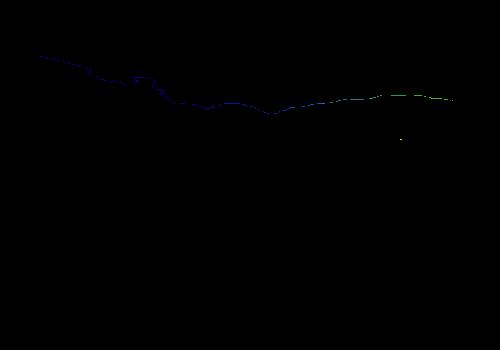

In [52]:
width = 500
height = 350

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # exciting!

In [43]:
response.geturl()

'https://geo.weather.gc.ca/geomet?service=WMS&version=1.3.0&request=GetMap&layers=DHPS_1km_RiverDischarge&styles=&width=500&height=350&crs=EPSG:4326&bbox=42,-78,47,-74&format=image/jpeg&transparent=TRUE&bgcolor=0xFFFFFF&exceptions=XML&time=2022-04-26T13:00:00Z&dim_reference_time=2022-04-26T12:00:00Z'

First tip, you need to indicate the style you want in the getmap request.  

What's strange is that it seems to default to RiverDischarge_XL, which is not the default.

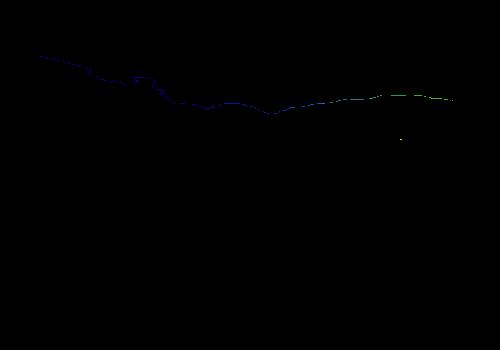

In [47]:
width = 500
height = 350

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      styles=['RiverDischarge_XL'], # this only shows large rivers
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # still not exciting!

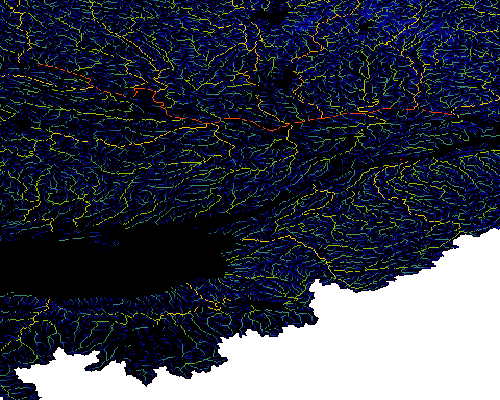

In [46]:
width = 500
height = 400

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/png',
                      srs='EPSG:4326',
                      styles=['RiverDischarge'],  # this is supposed to be the default
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # better!

## Viewing with Matplotlib / Cartopy

Text(0.5, 1.0, 'WMS example - Layer : DHPS_1km_RiverDischarge')

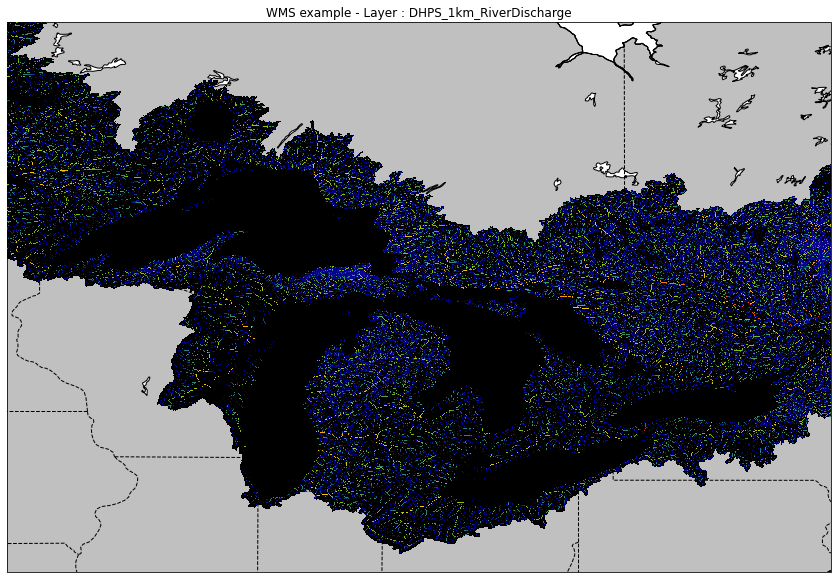

In [44]:
layer_name = 'DHPS_1km_RiverDischarge'
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

fig = plt.figure(figsize=(12,10))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

ax.set_extent([-93, -75, 40, 52])

fig.tight_layout(pad=2)

# features
edgecolor = 'black'

# Cartopy features 
ax.add_feature(cf.LAND, facecolor='silver', edgecolor=edgecolor)
ax.add_feature(cf.COASTLINE, edgecolor=edgecolor)
ax.add_feature(cf.LAKES, facecolor="white", edgecolor=edgecolor)

# Natural Earth Features
countries = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries_lakes',
        scale='10m',
        edgecolor=edgecolor,
        facecolor='none')
borders = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        edgecolor=edgecolor,
        facecolor='none')

ax.add_feature(countries)
ax.add_feature(borders, linestyle='dashed')

ax.add_wms(wms=wms, 
           layers=[layer_name], 
           wms_kwargs = {'transparent' : True, 'styles' : ['RiverDischarge']}, 
           zorder=10)

ax.set_title(f'WMS example - Layer : {layer_name}')

## Web Coverage Service Examples

In [47]:
# connect using auth / Authentication method 
# (note that username and password parameters individually are not accepted by WebCoverageService)
layer_name = 'DHPS_1km_RiverDischarge'

wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    version='2.0.1',
                    timeout=300
                    )

In [48]:
for key in list(wcs.contents.keys()):
    if "DHPS" in key:
        print(key)

DHPS_1km_RiverDischarge


In [51]:
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', 45.0, 58.0), ('lon', -70.0, -52.0)],
                    TIME='2022-04-27T14:00:00Z', 
                    DIM_REFERENCE_TIME='2022-04-27T00:00:00Z'
                   )

<div class="alert alert-block alert-warning">
<b>
There is a suspected issue with the way the time parameters are handled with the getCoverage method. Both time and dim_reference_time must be capitalized for these parameters to be recognized by the GetCoverage service.
</div>

In [52]:
# let's look at the request URL
response.geturl()

'https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=DHPS_1km_RiverDischarge&format=image/netcdf&subsettingcrs=EPSG:4326&TIME=2022-04-27T14:00:00Z&DIM_REFERENCE_TIME=2022-04-27T00:00:00Z&subset=lat(45.0,58.0)&subset=lon(-70.0,-52.0)'

In [54]:
# read into an xarray
ds = xr.open_dataset(response.read()).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 1560, lon: 2100)
Coordinates:
  * lat      (lat) float64 45.0 45.01 45.02 45.03 ... 57.97 57.98 57.99 58.0
  * lon      (lon) float64 -70.0 -69.99 -69.98 -69.97 ... -52.52 -52.51 -52.5
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.1.3, released 2020/09/01
    history:                      Wed Apr 27 15:43:44 2022: GDAL CreateCopy( ...

<div class="alert alert-block alert-warning">
<b>
Note: No visible time dimension in the layer data. We are looking into if this is an error or if this is by design.
</div>

Text(0.5, 1.0, 'WMS example - Layer : DHPS_1km_RiverDischarge')

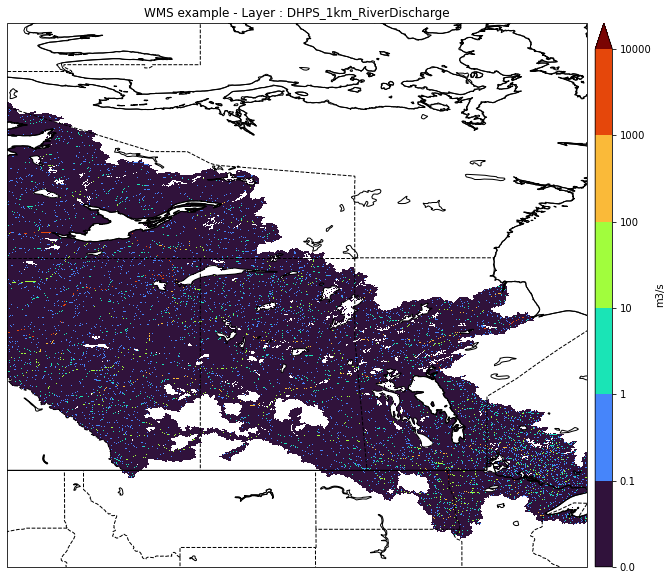

In [56]:
# The Prairies
north = 72
south = 44
east = -90
west = -120
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', south, north), ('lon', west, east)]
                   )
ds = xr.open_dataset(response.read()).load()

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(-70))
ax.set_extent([west, east, south, north])

levels = [0.01, 0.1, 1, 10, 100, 1000, 10000]
ticks = levels.copy()
cmap = plt.get_cmap("turbo").copy()
#cmap.set_under("#ececec")

x = ds['lon']
y = ds['lat']
z = ds["Band1"]
p = ax.pcolormesh(x, y, z,
                  transform=ccrs.PlateCarree(), 
                  cmap=cmap, norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='max'),
                  shading='auto')

ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, facecolor='none', edgecolor='black')

# Natural Earth Features
countries = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries_lakes',
        scale='10m',
        edgecolor=edgecolor,
        facecolor='none')
borders = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        edgecolor=edgecolor,
        facecolor='none')

ax.add_feature(countries)
ax.add_feature(borders, linestyle='dashed')

# add colorbar as separate axis and make it the right size
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cb = plt.colorbar(p, cax=cax, ticks=ticks, label='m3/s')
cb.ax.set_yticklabels(["{:.0f}".format(i) if i >= 1 else "{:.1f}".format(i) for i in cb.get_ticks()])

ax.set_title(f'WMS example - Layer : {layer_name}')